[![Map Pipeline](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml)
[![Lint](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml)
<a target="_blank" href="https://colab.research.google.com/github/YertleTurtleGit/depth-from-normals">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<!-- START doctoc generated TOC please keep comment here to allow auto update -->
<!-- END doctoc generated TOC please keep comment here to allow auto update -->

# Introduction


This algorithm estimates a 3d integral with the normal mapping with surface integrals of vector fields. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.


# Quickstart

In [2]:
from height_map import (
    estimate_height_map,
)  # local file 'height_map.py' in this repository
from matplotlib import pyplot as plt
import numpy as np
from skimage import io

NORMAL_MAP_A_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_a.png"  # @param {type: "string"}
NORMAL_MAP_B_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_b.png"
NORMAL_MAP_A_IMAGE: np.ndarray = io.imread(NORMAL_MAP_A_PATH)
NORMAL_MAP_B_IMAGE: np.ndarray = io.imread(NORMAL_MAP_B_PATH)

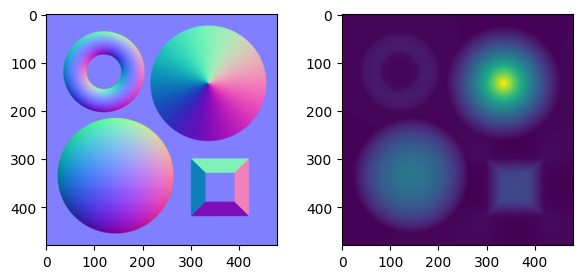

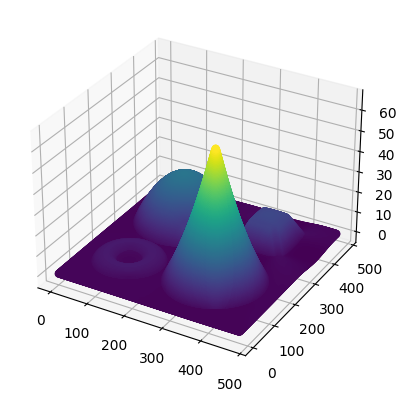

In [6]:
heights = estimate_height_map(NORMAL_MAP_A_IMAGE, raw_values=True)

figure, axes = plt.subplots(1, 2, figsize=(7, 3))
_ = axes[0].imshow(NORMAL_MAP_A_IMAGE)
_ = axes[1].imshow(heights)

x, y = np.meshgrid(range(heights.shape[1]), range(heights.shape[0]))
_, axes = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
_ = axes.scatter(x, y, heights, c=heights)

# Imports & Inputs

In [ ]:
import cv2 as cv
from scipy.integrate import cumulative_trapezoid, simpson
from multiprocessing.pool import ThreadPool as Pool
from math import sin, cos, radians, pi
from typing import List, Tuple
from matplotlib.colors import TwoSlopeNorm

# Explanation


## Gradients

First we calculate the anisotropic (directional) gradients from our normal map.

Given the normal vector $\vec{n} \in \mathbb{R}^{3}$ and a rotation value $r \in \mathbb{R}[0,2\pi]$, the anisotropic gradients are calculated:

$$
a_h = \arccos{\vec{n_x}}, \hspace{5px} g_l = (1 - \sin{a_h}) * sgn(a_h - \frac{\pi}{2})
$$

$$
a_v = \arccos{\vec{n_y}}, \hspace{5px} g_t = (1 - \sin{a_v}) * sgn(a_v - \frac{\pi}{2})
$$

This will be calculated for every pixel and for every rotation value.


In [ ]:
def calculate_gradients(normals: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    horizontal_angle_map = np.arccos(np.clip(normals[:, :, 0], -1, 1))
    left_gradients = (1 - np.sin(horizontal_angle_map)) * np.sign(
        horizontal_angle_map - pi / 2
    )

    vertical_angle_map = np.arccos(np.clip(normals[:, :, 1], -1, 1))
    top_gradients = -(1 - np.sin(vertical_angle_map)) * np.sign(
        vertical_angle_map - pi / 2
    )

    return left_gradients, top_gradients


normals = ((NORMAL_MAP_A_IMAGE[:, :, :3] / 255) - 0.5) * 2
left_gradients, top_gradients = calculate_gradients(normals)


figsize = (14, 14)
figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("anisotropic left gradients (left to right)")
_ = axes[0].imshow(left_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[1].set_title("anisotropic top gradients (top to bottom)")
_ = axes[1].imshow(top_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[2].set_title("normals (clipped)")
_ = axes[2].imshow(np.clip(normals, 0, 255))

## Heights

The height values $h(x,y) \in \mathbb{R}^{2}, \ \ x,y \in \mathbb{N}^{0}$ can be calculated by a cumulative sum over the gradients which converges to an integral over $g(x,y)$:

$$
h(x_t,y_t) = \iint g(x,y) dydx \ \ (x_t,y_t) \approx \sum_{x_i=0}^{x_t} g(x_i,y_t)
$$

The isotropic (non-directional) heights are determined with a combination of all anisotropic heights.


In [ ]:
def integrate_gradient_field(gradient_field: np.ndarray, axis: int) -> np.ndarray:
    return np.cumsum(gradient_field, axis=axis)


def calculate_heights(
    left_gradients: np.ndarray, top_gradients: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    left_heights = integrate_gradient_field(left_gradients, axis=1)
    right_heights = np.fliplr(
        integrate_gradient_field(np.fliplr(-left_gradients), axis=1)
    )
    top_heights = integrate_gradient_field(top_gradients, axis=0)
    bottom_heights = np.flipud(
        integrate_gradient_field(np.flipud(-top_gradients), axis=0)
    )
    return left_heights, right_heights, top_heights, bottom_heights


left_heights, right_heights, top_heights, bottom_heights = calculate_heights(
    left_gradients, top_gradients
)


def combine_heights(*heights: np.ndarray) -> np.ndarray:
    return np.mean(heights, axis=0)


isotropic_heights = combine_heights(
    left_heights, right_heights, top_heights, bottom_heights
)


def visualize_heights(heights_list: List[np.ndarray], labels: List[str]):
    if len(heights_list) == 1:
        heights = heights_list[0]
        plt.title(labels[0])
        _ = plt.imshow(heights)
        x, y = np.meshgrid(range(heights.shape[1]), range(heights.shape[0]))
        _, axes = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
        _ = axes.scatter(x, y, heights, c=heights)
        return

    figure, axes = plt.subplots(1, len(heights_list), figsize=(19, 5))
    for index, heights in enumerate(heights_list):
        axes[index].set_title(labels[index])
        _ = axes[index].imshow(heights, norm=TwoSlopeNorm(0.5))

    x, y = np.meshgrid(range(left_heights.shape[0]), range(left_heights.shape[1]))
    figure, axes = plt.subplots(
        1, len(heights_list), subplot_kw={"projection": "3d"}, figsize=(19, 5)
    )
    for index, heights in enumerate(heights_list):
        _ = axes[index].scatter(x, y, heights, c=heights)


visualize_heights(
    [left_heights, right_heights, top_heights, bottom_heights, isotropic_heights],
    [
        "anisotropic left heights",
        "anisotropic right heights",
        "anisotropic top heights",
        "anisotropic bottom heights",
        "isotropic heights",
    ],
)

## Rotation

This alone is very prone for errors. That’s why rotation is introduced. When re-calculating the gradient map multiple times with a rotation factor and using that to calculate the height values for every re-calculated gradient map, adding this values together drastically improves the resulting height values:

$$
h(x_t,y_t) = \sum_{r=0}^{2\pi} \sum_{x_i=0}^{x_t} g R_\theta (x_i,y_t)
$$

If we think of the left, right, top and bottom height maps in polar coordinates, we better call them 180°, 0°, 90° and 270° height maps.


In [ ]:
plt.polar()
_ = plt.yticks([1])

If we want to for example calculate a 225° anisotropic height map, we need to rotate the normal map first, but a simple image-rotation will result in wrong normals. Thus, we also need to rotate the normals accordingly.


In [ ]:
ANGLE = 225


def rotate(matrix: np.ndarray, angle: float) -> np.ndarray:
    image_size = (matrix.shape[1], matrix.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    rotation_matrix = np.matrix(
        np.vstack([cv.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]])
    )
    translation_matrix = np.matrix(np.identity(3))

    w2 = image_size[0] * 0.5
    h2 = image_size[1] * 0.5

    rot_mat_notranslate = np.matrix(rotation_matrix[0:2, 0:2])

    tl = (np.array([-w2, h2]) * rot_mat_notranslate).A[0]
    tr = (np.array([w2, h2]) * rot_mat_notranslate).A[0]
    bl = (np.array([-w2, -h2]) * rot_mat_notranslate).A[0]
    br = (np.array([w2, -h2]) * rot_mat_notranslate).A[0]

    x_coords = [pt[0] for pt in [tl, tr, bl, br]]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in [tl, tr, bl, br]]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))
    new_image_size = (new_w, new_h)

    new_midx = new_w * 0.5
    new_midy = new_h * 0.5

    dx = int(new_midx - w2)
    dy = int(new_midy - h2)

    translation_matrix = np.matrix(np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]]))
    affine_mat = (np.matrix(translation_matrix) * rotation_matrix)[0:2, :]
    result = cv.warpAffine(matrix, affine_mat, new_image_size, flags=cv.INTER_LINEAR)

    return result


rotated_normal_map_wrong = rotate(NORMAL_MAP_A_IMAGE, ANGLE)

wrong_normals = (
    (rotated_normal_map_wrong[:, :, :3].astype(np.float64) / 255) - 0.5
) * 2


def rotate_vector_field_normals(normals, angle):
    rotated_normals = normals.copy()
    rotated_normals[:, :, 0] = normals[:, :, 0] * cos(radians(angle))
    rotated_normals[:, :, 0] -= normals[:, :, 1] * sin(radians(angle))
    rotated_normals[:, :, 1] = normals[:, :, 0] * sin(radians(angle))
    rotated_normals[:, :, 1] += normals[:, :, 1] * cos(radians(angle))
    return rotated_normals


rotated_normals = rotate_vector_field_normals(wrong_normals, ANGLE)
rotated_normal_map = (((rotated_normals + 1) / 2) * 255).astype(np.uint8)

figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("normal map")
_ = axes[0].imshow(NORMAL_MAP_A_IMAGE)
axes[1].set_title("rotated normal map (wrong)")
_ = axes[1].imshow(rotated_normal_map_wrong)
axes[2].set_title("rotated normal map (correct)")
_ = axes[2].imshow(rotated_normal_map)

In [ ]:
def centered_crop(image: np.ndarray, target_resolution: Tuple[int, int]) -> np.ndarray:
    return image[
        (image.shape[0] - target_resolution[0])
        // 2 : (image.shape[0] - target_resolution[0])
        // 2
        + target_resolution[0],
        (image.shape[1] - target_resolution[1])
        // 2 : (image.shape[1] - target_resolution[1])
        // 2
        + target_resolution[1],
    ]

In [ ]:
def integrate_vector_field(
    vector_field: np.ndarray, target_iteration_count: int
) -> np.ndarray:
    shape = vector_field.shape[:2]
    angles = np.linspace(0, 90, target_iteration_count, endpoint=False)
    thread_count = 4

    def integrate_vector_field_angles(angles: List[float]) -> np.ndarray:
        all_combined_heights = np.zeros(shape)

        for angle in angles:
            rotated_vector_field = rotate_vector_field_normals(
                rotate(vector_field, angle), angle
            )

            left_gradients, top_gradients = calculate_gradients(rotated_vector_field)
            (
                left_heights,
                right_heights,
                top_heights,
                bottom_heights,
            ) = calculate_heights(left_gradients, top_gradients)

            combined_heights = combine_heights(
                left_heights, right_heights, top_heights, bottom_heights
            )
            combined_heights = centered_crop(rotate(combined_heights, -angle), shape)
            all_combined_heights += combined_heights / len(angles)

        return all_combined_heights

    with Pool(processes=thread_count) as pool:
        heights = pool.map(
            integrate_vector_field_angles,
            np.array(
                np.array_split(angles, thread_count),
                dtype=object,
            ),
        )
        pool.close()
        pool.join()

    isotropic_height = np.zeros(shape)
    for height in heights:
        isotropic_height += height / thread_count

    return isotropic_height


def estimate_height_map(
    normal_map: np.ndarray, target_iteration_count: int = 250
) -> np.ndarray:
    normals = ((normal_map[:, :, :3] / 255) - 0.5) * 2
    heights = integrate_vector_field(normals, target_iteration_count)
    return heights


figure, axes = plt.subplots(1, 4, figsize=(14, 6))

for index in range(4):
    target_iteration_count = max(1, index * 5)
    heights = estimate_height_map(NORMAL_MAP_B_IMAGE, target_iteration_count)
    x, y = np.meshgrid(range(heights.shape[0]), range(heights.shape[1]))

    axes[index].set_title(f"target iteration count: {target_iteration_count}")
    _ = axes[index].imshow(heights)

# Discussion

## Integration

Cumulative sum is a a very primitive way of calculating an integral. In the following the trapezoid and the Simpson method are implemented additionally.

In [ ]:
from enum import auto, Enum


class INTEGRATION_METHODS(Enum):
    SUM = auto()
    TRAPEZOID = auto()
    SIMSPSON = auto()


def integrate_gradient_field(gradient_field: np.ndarray, axis: int) -> np.ndarray:
    if INTEGRATION_METHOD == INTEGRATION_METHOD.SUM:
        return np.cumsum(gradient_field, axis=axis)

    if INTEGRATION_METHOD == INTEGRATION_METHOD.TRAPEZOID:
        return cumulative_trapezoid(gradient_field, axis=axis, initial=0)

    if INTEGRATION_METHOD == INTEGRATION_METHOD.SIMSPSON:
        integral = np.zeros(gradient_field.shape[:2])

        if axis == 1:
            for y in range(gradient_field.shape[0]):
                for x in range(1, gradient_field.shape[1]):
                    integral[y, x] = simpson(gradient_field[y, :x])

        elif axis == 0:
            for x in range(gradient_field.shape[1]):
                for y in range(1, gradient_field.shape[0]):
                    integral[y, x] = simpson(gradient_field[:y, x])

        return integral

    raise NotImplementedError(
        f"Integration method '{INTEGRATION_METHOD}' not implemented."
    )


target_iteration_count = 1


INTEGRATION_METHOD = INTEGRATION_METHODS.TRAPEZOID
trapezoid_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

INTEGRATION_METHOD = INTEGRATION_METHODS.SIMSPSON
simpson_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

INTEGRATION_METHOD = INTEGRATION_METHODS.SUM
sum_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

visualize_heights(
    [sum_heights, trapezoid_heights, simpson_heights], ["sum", "trapezoid", "Simpson"]
)

They all look quite the same and in fact, they are pretty much equal. However, the Simpson approach takes a very long computational time in this implementation, compared to sum and trapezoid.

This is quite demotivating in regard of using polynomial approximation in general to improve the resulting heights.

## Confidence

A simple approach to calculate the confidence of a pixel is to override the heights combination function to return the negative standard deviation instead of the mean.

In [ ]:
def combine_heights(*heights: np.ndarray) -> np.ndarray:
    return -np.std(heights, axis=0)


confidences = estimate_height_map(NORMAL_MAP_A_IMAGE)
plt.title("confidences")
plt.xlabel(f"mean: {np.mean(confidences)}")
_ = plt.imshow(confidences)
_ = plt.colorbar()